In [1]:
import torch, torchdata, torchtext
from torch import nn
import torch.nn.functional as F

import random, math, time

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

c:\Users\anhng\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


In [2]:
torch.__version__

'1.13.1+cpu'

In [2]:
torchtext.__version__

'0.14.1'

# 1. Load data - Wiki Text

In [3]:
import pandas as pd
df = pd.read_csv('./data/data.csv')
df.head()

,spanish,english
0,Ve.,Go.
1,Vete.,Go.
2,Vaya.,Go.
3,Váyase.,Go.
4,Hola.,Hi.


In [5]:
dataset = df.values.tolist()

# 2. EDA - simple investigation

In [6]:
dataset_size = len(dataset)
dataset_size

25064

In [7]:
import random
from torch.utils.data import random_split

# Shuffle the dataset
random.shuffle(dataset)

# Calculate the size of the training set
train_size = int(len(dataset) * 0.8)

# Split the dataset into train, validation, and test sets
train, val, test = random_split(
    dataset, 
    lengths=[train_size, int(len(dataset)*0.2), len(dataset)-train_size-int(len(dataset)*0.2)],
    generator=torch.Generator().manual_seed(999)
)

In [8]:
assert sum((len(train),len(val),len(test))) == dataset_size

# 3. Preprocessing

In [9]:
from attacut import tokenize, Tokenizer

# tokenize `txt` using our best model `attacut-sc`
txt = 'ApareciÃ³ un gato de abajo del escritorio.'
words = tokenize(txt)
print(words)
# alternatively, an AttaCut tokenizer might be instantiated directly, allowing
# one to specify whether to use `attacut-sc` or `attacut-c`.
atta = Tokenizer(model="attacut-sc")
words = atta.tokenize(txt)
words

['ApareciÃ', '³', ' ', 'un', ' ', 'gato', ' ', 'de', ' ', 'abajo', ' ', 'del', ' ', 'escritorio', '.']


['ApareciÃ',
 '³',
 ' ',
 'un',
 ' ',
 'gato',
 ' ',
 'de',
 ' ',
 'abajo',
 ' ',
 'del',
 ' ',
 'escritorio',
 '.']

In [10]:
SRC_LANGUAGE = 'spa'
TRG_LANGUAGE = 'en'
# Place-holders
token_transform = {}
vocab_transform = {}

In [11]:
from attacut import tokenize, Tokenizer
from torchtext.data.utils import get_tokenizer
token_transform[SRC_LANGUAGE] = Tokenizer(model="attacut-sc")
token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

In [12]:
#example of tokenization of the thai part
print("Sentence: ", train[0][0])
print("Tokenization: ", token_transform[SRC_LANGUAGE].tokenize(train[0][0]))

Sentence:  Eso es peligroso.
Tokenization:  ['Eso', ' ', 'es', ' ', 'peligroso', '.']


In [13]:
#example of tokenization of the english part
print("Sentence: ", train[0][1])
print("Tokenization: ", token_transform[TRG_LANGUAGE](train[0][1]))

Sentence:  That's dangerous.
Tokenization:  ['That', "'s", 'dangerous', '.']


In [14]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        if language == SRC_LANGUAGE:
            yield token_transform[language].tokenize(data_sample[language_index[language]])
        elif language == TRG_LANGUAGE:
            yield token_transform[language](data_sample[language_index[language]])

In [15]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

In [16]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train, ln), 
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [18]:
#see some example
vocab_transform[SRC_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[0, 157, 9, 0, 9]

In [19]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 1816, for example
mapping[1891]

'vieja'

In [20]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [21]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [22]:
#check unique vocabularies
len(mapping)

4022

# 4.  Preparing the dataloader

In [23]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import multiprocessing as mp
BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    global func
    def func(txt_input):
        for transform in transforms:
            if transform == token_transform[SRC_LANGUAGE]:
                txt_input = transform.tokenize(txt_input)
            else:
                txt_input = transform(txt_input)
        return txt_input

    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor

# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)
    import pickle
        
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

In [24]:
text_transform

{'spa': <function __main__.func(txt_input)>,
 'en': <function __main__.func(txt_input)>}

In [25]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
test_loader  = DataLoader(test, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_batch)

In [26]:
for en, _, spa in train_loader:
    break

In [27]:
print("Spanishshape: ", spa.shape)  # (seq len, batch_size)
print("English shape: ", en.shape)   # (seq len, batch_size)

Spanishshape:  torch.Size([9, 32])
English shape:  torch.Size([13, 32])


In [28]:
train_loader_length = 492
val_loader_length = 123
test_loader_length = 154

In [29]:
train_loader_length, val_loader_length, test_loader_length  

(492, 123, 154)

# 5. Design the model

### Encoder

In [30]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn       = nn.GRU(emb_dim, hid_dim, bidirectional=True)
        self.fc        = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout   = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src: [src len, batch size]
        #src len: [batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, 
                            src_len.to('cpu'), enforce_sorted=False)
        
        #packed_outputs contain all hidden states including padding guy
        #hidden contains the last hidden states of the non-padded guys
        packed_outputs, hidden = self.rnn(packed_embedded)
        #hidden: [n layers * num directions, batch size, hid dim]
        
        #convert packed_outputs to the guy that does not contain hidden states for padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        #outputs: [src len, batch size, hid dim * num directions]
        
        #take the last hidden states from backward and forward
        #hidden: (f, b, f, b)
        forward  = hidden[-2, :, :]  #[batch size, hid dim]
        backward = hidden[-1, :, :]  #[batch size, hid dim]
        
        hidden = torch.tanh(self.fc(torch.cat((forward, backward), dim = 1))) 
        #hidden: [batch size, hid dim]
        
        return outputs, hidden 

### Attention

In [31]:
class Attention(nn.Module):
    def __init__(self, hid_dim, variants):
        super().__init__()
        self.variants = variants
        self.v = nn.Linear(hid_dim, 1, bias=False)
        self.W = nn.Linear(hid_dim, hid_dim)  # for decoder
        self.U = nn.Linear(hid_dim * 2, hid_dim)  # for encoder outputs

    def forward(self, hidden, encoder_outputs, mask):

        # hidden = [batch size, hid dim]
        # encoder_outputs = [src len, batch size, hid dim * 2]

        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs = [batch size, src len, hid dim * 2]

        if self.variants == 'additive':
            # repeat decoder hidden state src_len times
            hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
            # hidden = [batch size, src len, hid dim]

            energy = torch.tanh(self.W(hidden) + self.U(encoder_outputs))
            # energy = [batch size, src len, hid dim]

            attention = self.v(energy).squeeze(2)
            # attention = [batch size, src len]

        elif self.variants == 'general':
            hidden = hidden.unsqueeze(1).repeat(1, 1, 2)
            # hidden = [batch size, 1, hid dim*2]
            # encoder_outputs = [batch size, hid dim * 2, src len]

            energy = torch.bmm(hidden, encoder_outputs.transpose(1, 2))
            attention = energy.squeeze(1)
            # attention = [batch size, src len]

        elif self.variants == 'multiplicative':
            # hidden = [batch size, hid dim]
            # encoder_outputs = [src len, batch size, hid dim * 2]

            hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
            # hidden = [batch size, src len, hid dim]

            encoder_outputs = encoder_outputs.transpose(0, 1)
            # encoder_outputs = [batch size, src len, hid dim * 2]

            energy = torch.sum(hidden * encoder_outputs, dim=2)
            # energy = [batch size, src len]

            attention = energy

        # use masked_fill_ if you want in-place
        attention = attention.masked_fill(mask, -1e10)
        # attention = [batch size, src len]

        return F.softmax(attention, dim=1)


In [32]:
#example of masked_fill
#reall that 1 is pad_idx
x = torch.tensor([ [9, 1, 7, 2, 1, 1], [99, 1, 1, 0, 8, 9] ])

mask = (x == PAD_IDX)

x.masked_fill_(mask, -1e10)
print(x)

tensor([[           9, -10000000000,            7,            2, -10000000000,
         -10000000000],
        [          99, -10000000000, -10000000000,            0,            8,
                    9]])


### Decoder

In [33]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()
        
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.gru = nn.GRU((hid_dim * 2) + emb_dim, hid_dim)
        self.fc = nn.Linear((hid_dim * 2) + hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
        
        #input = [batch size]
        #hidden = [batch size, hid dim]
        #encoder_outputs = [src len, batch size, hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
        #a = [batch size, src len]

        a = a.unsqueeze(1)
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs) #Ct
        #weighted = [batch size, 1, hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        #weighted = [1, batch size, hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        #rnn_input = [1, batch size, (hid dim * 2) + emb dim]
        
        output, hidden = self.gru(rnn_input, hidden.unsqueeze(0))
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [1, batch size, hid dim]
        assert (output == hidden).all()

        embedded = embedded.squeeze(0)
        output   = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc(torch.cat((output, weighted, embedded), dim = 1))
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

### Seq2SeqAttention

In [34]:
class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        #src: [src len, batch size]
        
        mask = (src == self.src_pad_idx).permute(1, 0)
        #mask: [batch size, src len]
        #we need to permute to make the mask same shape as attention...
        return mask

        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src: [src len, batch size]
        #src len: [batch size]
        #trg: [trg len, batch size]
        
        batch_size = src.shape[1]
        trg_len    = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim #define in decoder
        
        #because decoder decodes each step....let's create a list that gonna append the result to this guy
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #because decoder decodes each step....let's memorize the attention done in each step....
        attentions = torch.zeros(trg_len, batch_size, src.shape[0]).to(self.device)
        
        #let's start!!!
        #1. encoder
        encoder_outputs, hidden = self.encoder(src, src_len)
        #encoder_outputs: [src len, batch size, hid dim * num directions]
        #hidden: [batch size, hid dim]
        
        #set the first input to the decoder
        input_ = trg[0,:]  #basically <sos>
        
        #create the mask for use in this step
        mask = self.create_mask(src)
        
        #2. for each of trg word
        for t in range(1, trg_len):

            #3. decode (hidden is always carry forward)
            output, hidden, attention = self.decoder(input_, hidden, encoder_outputs, mask)
            #output:   [batch size, output_dim]
            #hidden:   [batch size, hid_dim]
            #attention::[batch size, src len]  ==> how each of src token is important to input_ 
            
            #4. append the results to outputs and attentions
            outputs[t] = output
            attentions[t] = attention
            
            #5. get the result, using argmax
            top1 = output.argmax(1)  #find the maximum index of dimension 1, which is output_dim
            
            #6. based on the teacher forcing ratio, 
            teacher_force_or_not = random.random() < teacher_forcing_ratio
                    #if teacher forcing, next input is the next trg
                    #if no teacher forcing, the next input is the argmax guy...
            input_ = trg[t] if teacher_force_or_not else top1  #autoregressive
            
        return outputs, attentions #outputs for predicting the word, attentions to see which word is important

# 6. Training

In [35]:
def initialize_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

General Attention

In [36]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
emb_dim     = 256  
hid_dim     = 512  
dropout     = 0.5
SRC_PAD_IDX = PAD_IDX

attn = Attention(hid_dim, variants='general')
enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)

model = Seq2SeqAttention(enc, dec, SRC_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqAttention(
  (encoder): Encoder(
    (embedding): Embedding(4022, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=512, out_features=1, bias=False)
      (W): Linear(in_features=512, out_features=512, bias=True)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(2490, 256)
    (gru): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=2490, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [37]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

1029632
393216
786432
  1536
  1536
393216
786432
  1536
  1536
524288
   512
   512
262144
   512
524288
   512
637440
1966080
786432
  1536
  1536
4462080
  2490
______
12565434


In [38]:
import torch.optim as optim

lr = 0.001

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

In [39]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    epoch_loss = 0
    
    for src, src_length, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output, attentions = model(src, src_length, trg)
        
        #trg    = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        
        #the loss function only works on 2d inputs with 1d targets thus we need to flatten each of them
        output = output[1:].view(-1, output_dim)
        trg    = trg[1:].view(-1)
        #trg    = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        #clip the gradients to prevent them from exploding (a common issue in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [40]:
def evaluate(model, loader, criterion, loader_length):
        
    #turn off dropout (and batch norm if used)
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_length, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, attentions = model(src, src_length, trg, 0) #turn off teacher forcing


            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [41]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [42]:
best_valid_loss = float('inf')
num_epochs = 5
clip       = 1

save_path = f'{model.__class__.__name__}_general.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 6m 25s
	Train Loss: 3.718 | Train PPL:  41.179
	 Val. Loss: 3.062 |  Val. PPL:  21.373
Epoch: 02 | Time: 7m 11s
	Train Loss: 2.561 | Train PPL:  12.943
	 Val. Loss: 2.494 |  Val. PPL:  12.112
Epoch: 03 | Time: 5m 58s
	Train Loss: 2.010 | Train PPL:   7.467
	 Val. Loss: 2.279 |  Val. PPL:   9.764
Epoch: 04 | Time: 6m 2s
	Train Loss: 1.603 | Train PPL:   4.969
	 Val. Loss: 2.145 |  Val. PPL:   8.542
Epoch: 05 | Time: 6m 4s
	Train Loss: 1.330 | Train PPL:   3.781
	 Val. Loss: 2.016 |  Val. PPL:   7.508


Text(0, 0.5, 'loss')

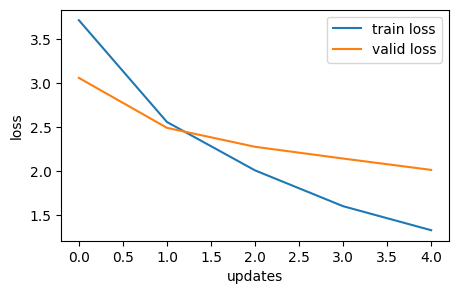

In [43]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [44]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.000 | Test PPL:   7.390 |


Multiplicative Attention

In [45]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
emb_dim     = 256  
hid_dim     = 512  
dropout     = 0.5
SRC_PAD_IDX = PAD_IDX

attn = Attention(hid_dim, variants='multiplicative')
enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)

model = Seq2SeqAttention(enc, dec, SRC_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqAttention(
  (encoder): Encoder(
    (embedding): Embedding(4022, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=512, out_features=1, bias=False)
      (W): Linear(in_features=512, out_features=512, bias=True)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(2490, 256)
    (gru): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=2490, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [46]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model_multi)

1029632
393216
786432
  1536
  1536
393216
786432
  1536
  1536
524288
   512
   512
262144
   512
524288
   512
637440
1966080
786432
  1536
  1536
4462080
  2490
______
12565434


In [47]:
import torch.optim as optim

lr = 0.001

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

In [48]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    epoch_loss = 0
    
    for src, src_length, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output, attentions = model(src, src_length, trg)
        
        #trg    = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        
        #the loss function only works on 2d inputs with 1d targets thus we need to flatten each of them
        output = output[1:].view(-1, output_dim)
        trg    = trg[1:].view(-1)
        #trg    = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        #clip the gradients to prevent them from exploding (a common issue in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [49]:
def evaluate(model, loader, criterion, loader_length):
        
    #turn off dropout (and batch norm if used)
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_length, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, attentions = model(src, src_length, trg, 0) #turn off teacher forcing

            #trg    = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg    = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [50]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [51]:
best_valid_loss = float('inf')
num_epochs = 5
clip       = 1

save_path = f'{model.__class__.__name__}_multiplicative.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


Epoch: 01 | Time: 6m 41s
	Train Loss: 3.825 | Train PPL:  45.839
	 Val. Loss: 3.269 |  Val. PPL:  26.294
Epoch: 02 | Time: 6m 1s
	Train Loss: 2.795 | Train PPL:  16.369
	 Val. Loss: 2.733 |  Val. PPL:  15.384
Epoch: 03 | Time: 6m 41s
	Train Loss: 2.255 | Train PPL:   9.536
	 Val. Loss: 2.477 |  Val. PPL:  11.904
Epoch: 04 | Time: 6m 15s
	Train Loss: 1.847 | Train PPL:   6.338
	 Val. Loss: 2.266 |  Val. PPL:   9.643
Epoch: 05 | Time: 6m 15s
	Train Loss: 1.560 | Train PPL:   4.757
	 Val. Loss: 2.143 |  Val. PPL:   8.522


Text(0, 0.5, 'loss')

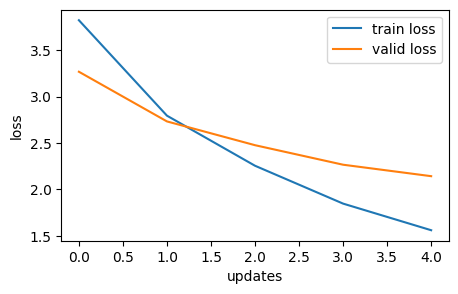

In [52]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [53]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.144 | Test PPL:   8.537 |


Additive Attention

In [54]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
emb_dim     = 256  
hid_dim     = 512  
dropout     = 0.5
SRC_PAD_IDX = PAD_IDX

attn = Attention(hid_dim, variants='additive')
enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)

model = Seq2SeqAttention(enc, dec, SRC_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqAttention(
  (encoder): Encoder(
    (embedding): Embedding(4022, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=512, out_features=1, bias=False)
      (W): Linear(in_features=512, out_features=512, bias=True)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(2490, 256)
    (gru): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=2490, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [55]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

1029632
393216
786432
  1536
  1536
393216
786432
  1536
  1536
524288
   512
   512
262144
   512
524288
   512
637440
1966080
786432
  1536
  1536
4462080
  2490
______
12565434


In [56]:
import torch.optim as optim

lr = 0.001

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

In [57]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    epoch_loss = 0
    
    for src, src_length, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output, attentions = model(src, src_length, trg)
        
        #trg    = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        
        #the loss function only works on 2d inputs with 1d targets thus we need to flatten each of them
        output = output[1:].view(-1, output_dim)
        trg    = trg[1:].view(-1)
        #trg    = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        #clip the gradients to prevent them from exploding (a common issue in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [58]:
def evaluate(model, loader, criterion, loader_length):
        
    #turn off dropout (and batch norm if used)
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_length, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, attentions = model(src, src_length, trg, 0) #turn off teacher forcing

            #trg    = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg    = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [59]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [60]:
best_valid_loss = float('inf')
num_epochs = 5
clip       = 1

save_path = f'{model.__class__.__name__}_additive.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 9m 1s
	Train Loss: 3.782 | Train PPL:  43.883
	 Val. Loss: 3.154 |  Val. PPL:  23.421
Epoch: 02 | Time: 8m 40s
	Train Loss: 2.610 | Train PPL:  13.602
	 Val. Loss: 2.551 |  Val. PPL:  12.817
Epoch: 03 | Time: 7m 40s
	Train Loss: 1.960 | Train PPL:   7.096
	 Val. Loss: 2.192 |  Val. PPL:   8.955
Epoch: 04 | Time: 7m 30s
	Train Loss: 1.526 | Train PPL:   4.597
	 Val. Loss: 2.063 |  Val. PPL:   7.867
Epoch: 05 | Time: 7m 37s
	Train Loss: 1.195 | Train PPL:   3.304
	 Val. Loss: 2.009 |  Val. PPL:   7.459


Text(0, 0.5, 'loss')

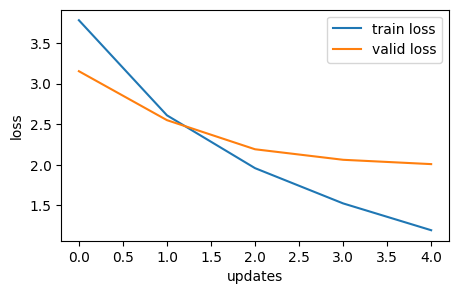

In [61]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [62]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.982 | Test PPL:   7.255 |


# Compare
The comparison between the three attention mechanisms based on the given information:

General Attention has the lowest test loss of 2.000 and the lowest test PPL of 7.390. This suggests that it performs better than the other two attention mechanisms in terms of predicting the target sequence.

Additive Attention has the lowest test PPL of 7.255, indicating that it generates the target sequence with the highest probability among the three attention mechanisms.

Multiplicative Attention has the highest test loss of 2.144 and the highest test PPL of 8.537, suggesting that it is the least effective attention mechanism in predicting the target sequence.